# LIft Taxi Project

in this project, for Sweet Lift Taxi company, i have historical data on taxi orders at airports. To attract more drivers during peak hours, i need to predict the amount of taxi orders for the next hour.i will build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

# What i will do:

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

# Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [5]:
pip install xgboost

     |████████████████████████████████| 1.7 MB 856 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
#Loading all the libraries i will use:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings("ignore")
import requests 
import io
from sklearn.model_selection import train_test_split
from sklearn import linear_model, decomposition, datasets
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from IPython import display
from IPython.display import Image
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from xgboost import XGBRegressor
import math


In [11]:
# Downloading the csv file from my GitHub account

url = "https://raw.githubusercontent.com/yoav-karsenty/Time-series/main/taxi.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

taxi = pd.read_csv(io.StringIO(download.decode('utf-8')),index_col=[0], parse_dates=[0])


# Exploring the data
taxi.head(7)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7


In [12]:
#getting more info about the data 
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [13]:
# Check if the index is having duplicate values
print("\nIs the Taxi index having duplicate values?\n",taxi.index.has_duplicates)


Is the Taxi index having duplicate values?
 False


In [14]:
taxi.sort_index(inplace=True)
taxi.head(12)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [15]:
#Resampling the data to 1 hour 
taxi = taxi.resample('1h').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

In [16]:
taxi.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

<AxesSubplot:xlabel='datetime'>

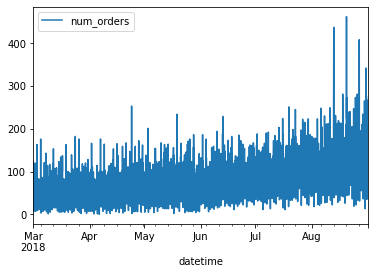

In [17]:
#Plotting the data 
taxi.plot()

In [18]:
#slicing the data so i could analyse it more clearly 
taxi_plot = taxi['2018-03-01':'2018-03-15']

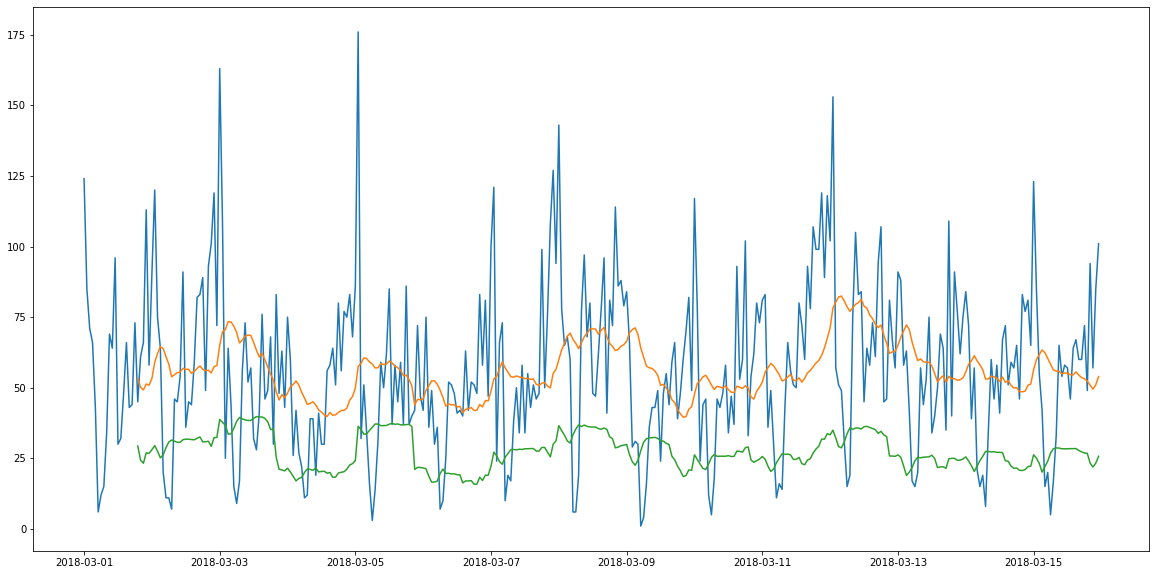

In [19]:
#Adding the the moving average and std to the plot
taxi_plot['mean'] = taxi_plot['num_orders'].rolling(20).mean()
taxi_plot['std'] = taxi_plot['num_orders'].rolling(20).std()

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111)
ax1.plot(taxi_plot)

 it looks like this time series is stationary. It does not depend on time, and it does not change so much.

Next, i want to see the Seasonality of the data, and see if therre are any patterns

In [39]:

decomposed = seasonal_decompose(taxi)

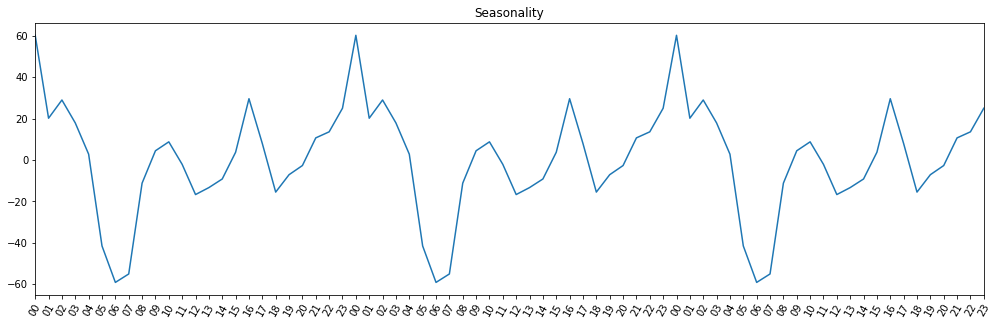

In [40]:
Y = decomposed.seasonal['2018-06-01':'2018-06-03'].values
x = decomposed.seasonal['2018-06-01':'2018-06-03'].index

fig = plt.figure(figsize=(17, 5))
ax1 = fig.add_subplot(111)
ax1.set_xlim(min(x), max(x))

ax1.set_xticks(x)
ax1.set_xticklabels(x.strftime('%H'));

ax1.plot(x, Y)
plt.title('Seasonality')
plt.xticks(rotation = 60)
plt.show()


We can see there are clearly some patterns. The high peaks are around 16:00 and 00:00 and the low peaks are arounf 06:00, 12:00 and 18:00. some possible reasons could be traffic to the airport, preffered flight times, and maybe times that is less convenient for some people to pick up their friends or family from the airport - the middle of the night, during work, etc..

## Training

Next, I will train different models and see if ican get a model to score less than 48 RMSE. 

In [43]:
#spliting the data into training set and test set 
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()
train_y = train['num_orders']
train_x = train.drop('num_orders', axis=1)
test_y = test['num_orders']
test_x = test.drop('num_orders', axis=1)

In [44]:
#Creating a sanit model that always predicts the median 
pred_median = np.ones(test_y.shape) * train_y.median()
print('MAE:', mean_absolute_error(test_y, pred_median))
print('RMSE:', math.sqrt(mean_squared_error(test_y, pred_median)))

MAE: 70.7918552036199
RMSE: 87.15277582981295


As expected, this model doesnt perform as well as we need. Next i will try a model that predicts using the previous value. 

In [45]:
pred_previous = test_y.shift()
pred_previous.iloc[0] = train_y.iloc[-1]
print('MAE:', mean_absolute_error(test_y, pred_previous))
print('RMSE:', math.sqrt(mean_squared_error(test_y, pred_previous)))

MAE: 44.97285067873303
RMSE: 58.856486242815066


Better, but still not good enough. I will now add more features to the data and try to train LinearRegression,RandomForestRegressor and XGBRegressor models. 

In [46]:
# A function that creates more features based on the data
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [19]:
# Tuning model performance based on the make_features arguments.
best_model = None
best_result = 60
best_i = 0
best_j = 0

for i in range(1,50):
    for j in range(1,50):
        taxi_feat = make_features(taxi, i, j)
        train, test = train_test_split(taxi_feat, shuffle=False, test_size=0.1)
        train,val = train_test_split(train, shuffle=False, test_size=0.2)
        train = train.dropna()
        train_y = train['num_orders']
        train_x = train.drop('num_orders', axis=1)
        val_y = val['num_orders']
        val_x = val.drop('num_orders',axis = 1)
        test_y = test['num_orders']
        test_x = test.drop('num_orders', axis=1)
        model = LinearRegression()
        model.fit(train_x, train_y)
        y_pred = model.predict(val_x)
        mse = mean_squared_error(val_y, y_pred)
        rmse = mse**(0.5)
        if rmse < best_result: 
            
            best_result = rmse
            best_i = i
            best_j = j
print("The best RMSE score:",best_result,"Best I : ",best_i,"best_j : ",best_j)

The best RMSE score: 30.24428691634277 Best I :  48 best_j :  22


In [47]:
taxi_feat = make_features(taxi, 48, 22)

In [48]:
train, test = train_test_split(taxi_feat, shuffle=False, test_size=0.1)
train,val = train_test_split(train, shuffle=False, test_size=0.2)

val_y = val['num_orders']
val_x = val.drop('num_orders',axis = 1)
        
train = train.dropna()
train_y = train['num_orders']
train_x = train.drop('num_orders', axis=1)
test_y = test['num_orders']
test_x = test.drop('num_orders', axis=1)

In [49]:
model = LinearRegression()
model.fit(train_x, train_y)
pred_train = model.predict(train_x)
pred_test = model.predict(val_x)

In [50]:
print("MAE for the training set:", mean_absolute_error(train_y, pred_train))
print("MAE on val: ", mean_absolute_error(val_y, pred_test))
print('RMSE on val:', math.sqrt(mean_squared_error(val_y, pred_test)))

MAE for the training set: 16.370060177948787
MAE on test:  22.682205772984762
RMSE on test: 30.344513334822366


Now we got a result that is good for us with 30.34 RMSE on the val set. I want to see if i can improve that. 

In [51]:
# Training RandomForestRegressor and using a loop to get the best parameters. 
best_model = None
best_result = 60
best_est = 0
best_depth = 0
est_list = [1, 2, 4, 8, 16, 32, 64, 100]
for est in est_list:
    for depth in range (1, 30,2):
        model = RandomForestRegressor(random_state=54321, n_estimators=est,max_depth = depth ) 
        model.fit(train_x,train_y) 
        y_pred = model.predict(val_x)
        
        mse = mean_squared_error(val_y, y_pred)
        rmse = mse**(0.5)
        if rmse < best_result: 
            
            best_result = rmse
            best_est = est
            best_depth = depth
print("The best RMSE score:",best_result,"Best est : ",best_est,"best_depth : ",best_depth)
 

The best RMSE score: 31.37679963453753 Best est :  64 best_depth :  15


In [52]:
x_model = XGBRegressor(n_estimators = 100,max_depth = 39,random_state = 12345 )


In [53]:
x_model.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=39, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=12345,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
xgbr_pred = x_model.predict(val_x)
mse = mean_squared_error(val_y, xgbr_pred)
rmse = mse**(0.5)
rmse

37.098273811384104

The best score we got was with the LinearRegression model, so next i will test that model using the test set 

# Testing

In [55]:
model = LinearRegression()
model.fit(train_x, train_y)
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)

In [57]:
print("MAE for the training set:", mean_absolute_error(train_y, pred_train))
print("MAE on test: ", mean_absolute_error(test_y, pred_test))
print('RMSE on test:', math.sqrt(mean_squared_error(test_y, pred_test)))

MAE for the training set: 16.370060177948787
MAE on test:  33.96922808745876
RMSE on test: 45.686277172004715


# Conclusions


In this project, i have analysed data from sweet lift taxi company, in order to train a model the can score less than 48 RMSE. 


The most efficient model i trained was :
    LinearRegression , using the make_features function with these parameters - make_features(taxi, 48, 22)
    
    
    
    
This models RMSE on the test set is is 45.68. 